<a href="https://colab.research.google.com/github/VanChung-Nguyen/Nonlinear-and-Data-Driven-Estimation-3D-Drone/blob/main/obserabilitydrone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.integrate import odeint
import scipy.optimize

import sympy as sp

import pandas as pd

import copy

In [2]:
try:
    import casadi
except:
    !pip install casadi
    import casadi

try:
    import do_mpc
except:
    !pip install do_mpc
    import do_mpc

try:
    import pybounds
except:
    #!pip install pybounds
    !pip install git+https://github.com/vanbreugel-lab/pybounds
    import pybounds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 MB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.9/162.9 kB 13.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/usr/local/lib/python3.12/dist-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


  Cloning https://github.com/vanbreugel-lab/pybounds to /tmp/pip-req-build-0p0oqxew
  Running command git clone --filter=blob:none --quiet https://github.com/vanbreugel-lab/pybounds /tmp/pip-req-build-0p0oqxew
  Resolved https://github.com/vanbreugel-lab/pybounds to commit de8cd11adc51f84c2a0057babb4f211a5a5d44cf
  Preparing metadata (setup.py) ... done
  Created wheel for pybounds: filename=pybounds-0.0.13-py3-none-any.whl size=19525 sha256=332ee20b4be889f2d9b56fada47eaf62734fb56481e0b991ed83a709f03a68ca
  Stored in directory: /tmp/pip-ephem-wheel-cache-cqse22gi/wheels/cb/f8/fb/ff1887f9a2f35c3edad7b1acb7da69437c1fd8d885a800578d
Successfully built pybounds


In [3]:
import sys
import requests
import importlib
import importlib.util
from pathlib import Path

def import_local_or_github(package_name, function_name=None, directory=None, giturl=None):
    # 1) Try local import
    try:
        if directory is not None:
            directory = str(Path(directory).resolve())
            if directory not in sys.path:
                sys.path.insert(0, directory)
        module = importlib.import_module(package_name)
        return getattr(module, function_name) if function_name else module
    except ModuleNotFoundError:
        pass  # fall through to GitHub fetch
    except Exception as e:
        # If module exists but some other error occurred, surface it
        raise

    # 2) Fetch from GitHub (RAW)
    if giturl is None:
        giturl = (
            "https://raw.githubusercontent.com/"
            "VanChung-Nguyen/ME-793-Mathematical-model-simulation-of-3D-Drone/"
            f"main/Utility/{package_name}.py"
        )

    try:
        headers = {"User-Agent": "import_local_or_github/1.0"}
        r = requests.get(giturl, headers=headers, timeout=15)
        r.raise_for_status()
    except requests.RequestException as e:
        raise RuntimeError(f"Failed to fetch module from GitHub URL:\n{giturl}\nError: {e}")

    # Save to CWD as {package_name}.py so Python can import it
    target_path = Path.cwd() / f"{package_name}.py"
    target_path.write_text(r.text, encoding=r.encoding or "utf-8")

    # Make sure Python sees the new file
    importlib.invalidate_caches()

    # 3) Import the freshly written module
    module = importlib.import_module(package_name)
    return getattr(module, function_name) if function_name else module


# Usage
drone = import_local_or_github('drone', directory='../Utility')
plot_tme = import_local_or_github('plot_utility', function_name='plot_tme', directory='../Utility')


In [7]:
f = drone.F().f
h = drone.H('h_opticalimu').h

In [24]:
t_sim, x_sim, u_sim, y_sim, simulator = drone.simulate_drone(f, h=h, dt=0.1, tsim_length= 40,trajectory_shape='lemniscate')

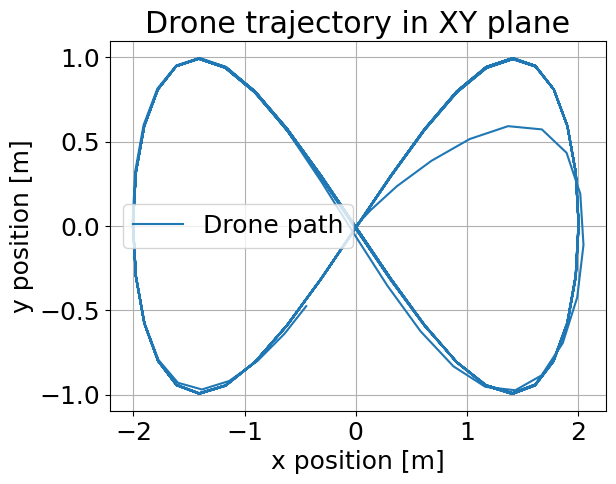

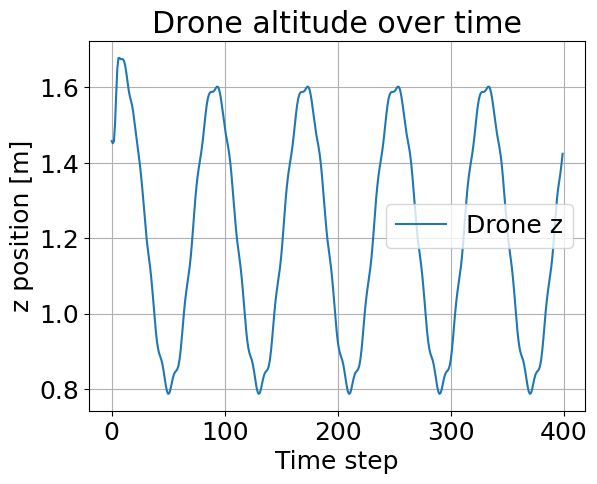

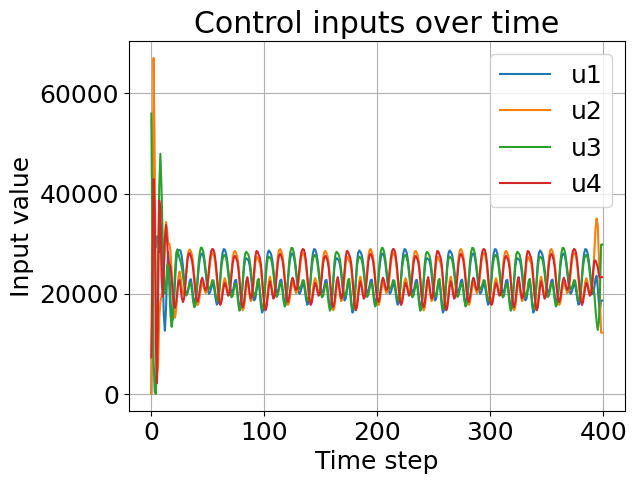

In [25]:
# === 1. Plot XY trajectory ===
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_sim['x'], x_sim['y'], label='Drone path')
ax.set_xlabel('x position [m]')
ax.set_ylabel('y position [m]')
ax.set_title('Drone trajectory in XY plane')
ax.legend()
ax.grid(True)
plt.show()

# === 2. Plot Z (altitude) over time ===
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.plot(x_sim['z'], label='Drone z')
ax1.set_xlabel('Time step')
ax1.set_ylabel('z position [m]')
ax1.set_title('Drone altitude over time')
ax1.legend()
ax1.grid(True)
plt.show()

# === 3. Plot control inputs (u_sim) ===
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

# Loop through each control input
for key in u_sim.keys():
    ax2.plot(u_sim[key], label=key)

ax2.set_xlabel('Time step')
ax2.set_ylabel('Input value')
ax2.set_title('Control inputs over time')
ax2.legend()
ax2.grid(True)
plt.show()


In [26]:
#noise gps-imu
#measurement_noise_stds = {'x': 0.1,
#                          'y': 0.1,
#                          'z': 0.1,
#                          'phi': 0.1,
#                          'theta': 0.1,
#                          'psi': 0.1,
#                          'phidot': 0.1,
#                          'thetadot': 0.1,
#                          'psidot': 0.1
#                         }

measurement_noise_stds = {'optic_flow_x': 0.25,
                          'optic_flow_y': 0.25,
                          'phi': 0.1,
                          'theta': 0.1,
                          'psi': 0.1,
                          'phidot': 0.1,
                          'thetadot': 0.1,
                          'psidot': 0.1,
                          'ax': 0.2,
                          'ay': 0.2,
                          'az': 0.2
                         }

In [27]:
u_sim_df = pd.DataFrame(u_sim)
x_sim_df = pd.DataFrame(x_sim)
w = 6

In [28]:
SEOM = pybounds.SlidingEmpiricalObservabilityMatrix(simulator, t_sim, x_sim, u_sim, w=w, eps=1e-4)

# Get O's
O_sliding = SEOM.get_observability_matrix()

In [30]:
n_window = len(O_sliding)
print(n_window, 'windows')

395 windows


In [31]:
O_sliding[0]

,,x,y,z,phi,theta,psi,xdot,ydot,zdot,phidot,thetadot,psidot
sensor,time_step,,,,,,,,,,,,
optic_flow_x,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.860183e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
optic_flow_y,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.860183e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
phi,0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
theta,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
psi,0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
thetadot,5,8.659740e-11,5.329071e-11,-1.110223e-11,3.730349e-10,3.996803e-10,-3.863576e-10,1.199041e-10,-6.661338e-11,-6.883383e-11,-3.132886e-02,9.995091e-01,0.126390
psidot,5,-3.469447e-14,-2.498002e-12,-1.144917e-12,-1.700029e-12,2.879641e-12,-4.510281e-13,9.714451e-13,-1.214306e-12,1.387779e-12,1.873501e-12,3.469447e-13,1.000000
ax,5,4.329870e-10,1.709743e-10,-3.108624e-11,-1.394007e+00,5.280021e+00,2.102538e+00,5.417888e-10,7.682743e-10,1.549871e-09,-7.391137e-01,2.628371e+00,1.011806


In [32]:
measurement_noise_vars = {key: val**2 for key, val in measurement_noise_stds.items()}

In [33]:
FO = pybounds.FisherObservability(SEOM.O_df_sliding[0], measurement_noise_vars, lam=1e-8)

In [34]:
F, F_inv, R = FO.get_fisher_information()
F_inv

,x,y,z,phi,theta,psi,xdot,ydot,zdot,phidot,thetadot,psidot
x,1.000000e+08,-5.172100e-01,-0.177167,0.000834,-4.644389e-04,-0.004338,-0.027691,0.037685,0.486436,-0.014477,-0.005305,-0.000805
y,-5.172100e-01,1.000000e+08,-0.058408,0.000314,-4.418433e-07,-0.001561,-0.011981,0.018199,0.150302,-0.005504,-0.002622,-0.000367
z,-1.771678e-01,-5.840730e-02,0.525998,-0.000132,9.512590e-05,-0.000146,0.073813,0.049452,-1.110648,0.000152,-0.000352,-0.000068
phi,8.340871e-04,3.135159e-04,-0.000132,0.000136,3.256334e-05,0.000166,-0.000042,0.000113,0.000212,-0.000160,-0.000008,-0.000066
theta,-4.644370e-04,-4.462825e-07,0.000095,0.000033,1.078279e-04,0.000102,-0.000068,0.000039,-0.000046,0.000049,-0.000227,-0.000023
psi,-4.337591e-03,-1.560781e-03,-0.000146,0.000166,1.018476e-04,0.000558,-0.000019,0.000025,0.000315,0.000136,-0.000033,-0.000405
xdot,-2.769073e-02,-1.198106e-02,0.073813,-0.000042,-6.758072e-05,-0.000019,0.049043,0.014478,-0.110546,-0.000017,0.000094,-0.000010
ydot,3.768525e-02,1.819933e-02,0.049452,0.000113,3.901286e-05,0.000025,0.014478,0.032768,-0.080847,-0.000046,0.000002,-0.000025
zdot,4.864368e-01,1.503002e-01,-1.110648,0.000212,-4.553339e-05,0.000315,-0.110546,-0.080847,2.486702,-0.000413,0.000961,0.000125
phidot,-1.447708e-02,-5.504319e-03,0.000152,-0.000160,4.923077e-05,0.000136,-0.000017,-0.000046,-0.000413,0.001301,0.000029,0.000408


In [35]:
o_sensors = h(None, None, return_measurement_names=True)

# Chose states to use from O
o_states = ['x', 'y', 'z', 'phi', 'theta', 'psi', 'xdot', 'ydot', 'zdot', 'phidot', 'thetadot', 'psidot']

# Choose time-steps to use from O
window_size = 6 # this cannot be larger than what was defined above
o_time_steps = np.arange(0, window_size, step=1)

# Redefine R -- if you remove a sensor you need to change R
o_measurement_noise_vars = {key: measurement_noise_vars[key] for key in o_sensors}

In [36]:
SFO = pybounds.SlidingFisherObservability(SEOM.O_df_sliding, time=SEOM.t_sim, lam=1e-8, R=o_measurement_noise_vars,
                                 states=o_states, sensors=o_sensors, time_steps=o_time_steps, w=None)

In [37]:
EV_aligned = SFO.get_minimum_error_variance()

In [38]:
EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')

/tmp/ipython-input-1416315243.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  EV_no_nan = EV_aligned.fillna(method='bfill').fillna(method='ffill')


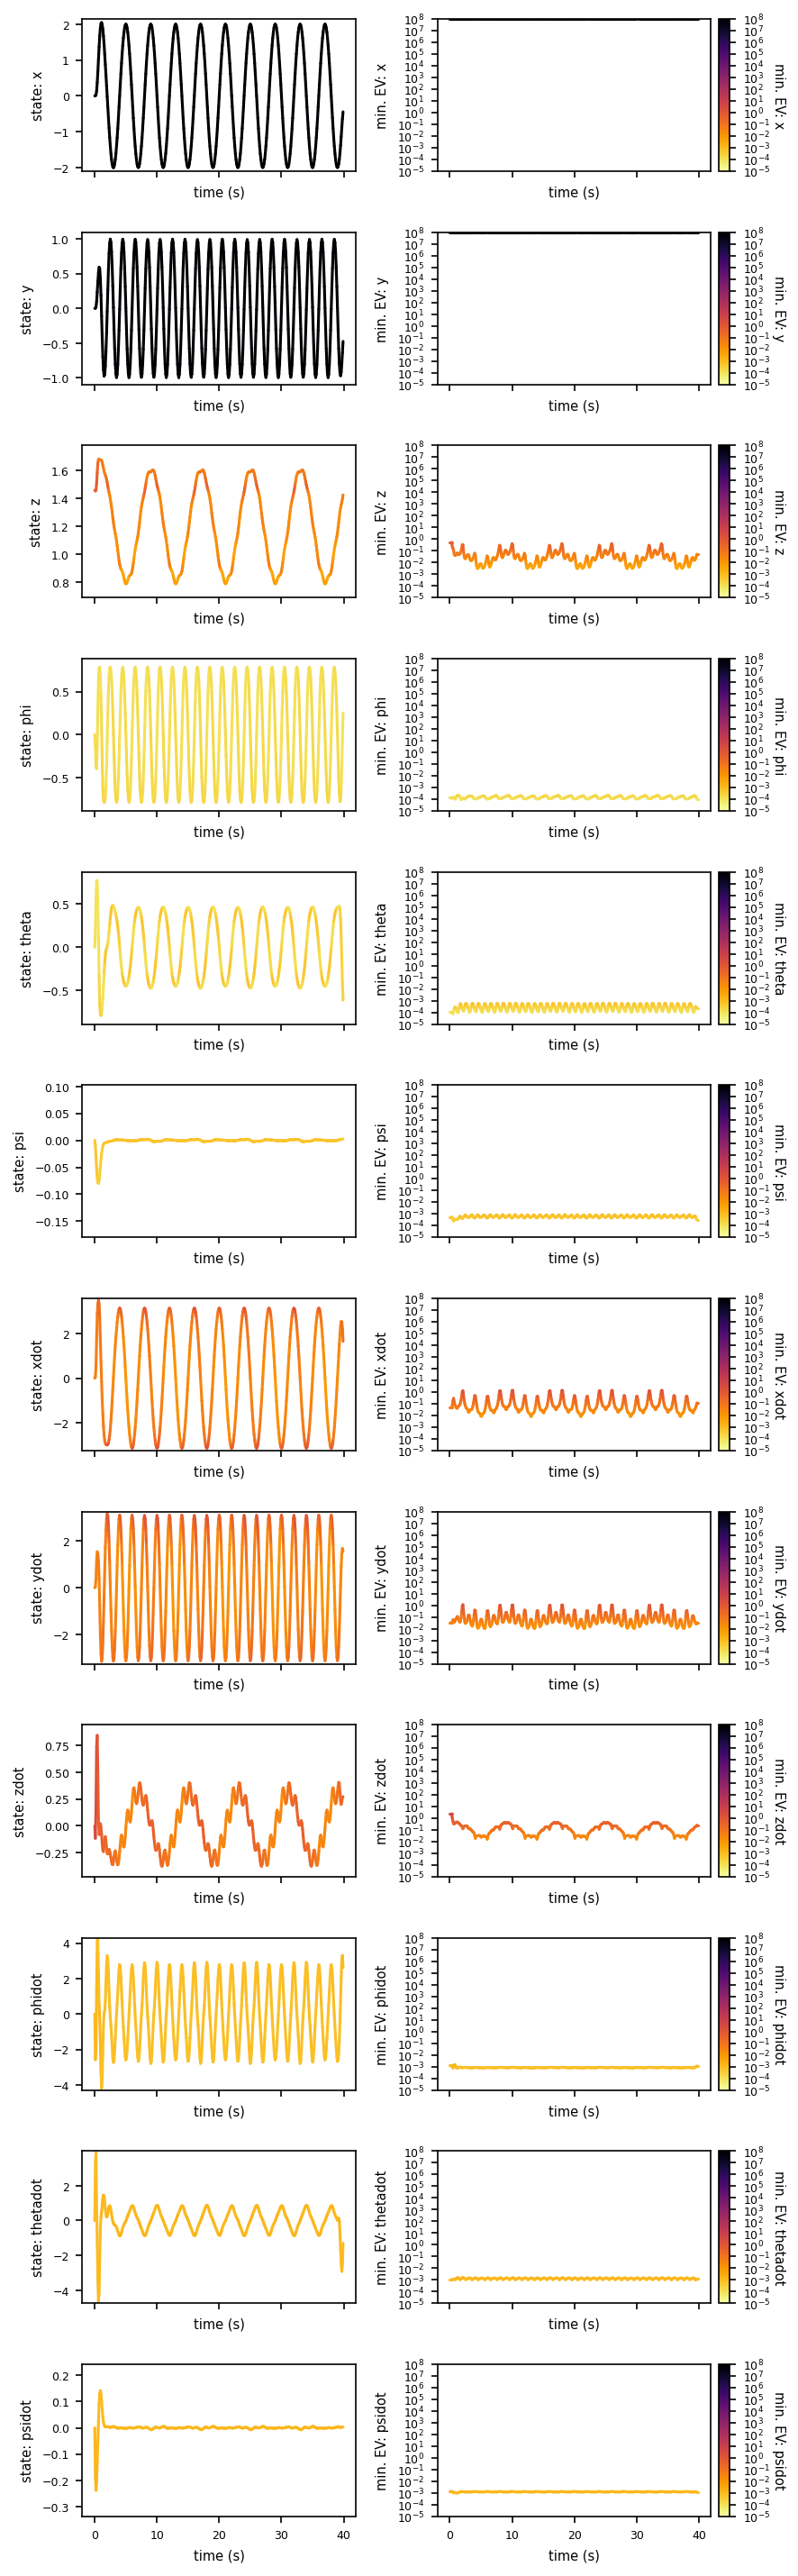

In [39]:
states = list(SFO.FO[0].O.columns)
n_state = len(states)

fig, ax = plt.subplots(n_state, 2, figsize=(6, n_state*2), dpi=150, sharex=True)
ax = np.atleast_2d(ax)

cmap = 'inferno_r'

min_ev = np.min(EV_no_nan.iloc[:, 2:].values)
max_ev = np.max(EV_no_nan.iloc[:, 2:].values)

log_tick_high = int(np.ceil(np.log10(max_ev)))
log_tick_low = int(np.floor(np.log10(min_ev)))
cnorm = mpl.colors.LogNorm(10**log_tick_low, 10**log_tick_high)

for n, state_name in enumerate(states):
    pybounds.colorline(t_sim, x_sim[state_name], EV_no_nan[state_name].values, ax=ax[n, 0], cmap=cmap, norm=cnorm)
    pybounds.colorline(t_sim, EV_no_nan[state_name].values, EV_no_nan[state_name].values, ax=ax[n, 1], cmap=cmap, norm=cnorm)

    # Colorbar
    cax = ax[n, -1].inset_axes([1.03, 0.0, 0.04, 1.0])
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=cnorm, cmap=cmap), cax=cax,
                        ticks=np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))
    cbar.set_label('min. EV: ' + state_name, rotation=270, fontsize=7, labelpad=8)
    cbar.ax.tick_params(labelsize=6)

    x_max = np.max(x_sim[state_name])
    x_min = np.min(x_sim[state_name])

    ax[n, 0].set_ylim(x_min - 0.1, x_max + 0.1)
    ax[n, 0].set_ylabel('state: ' + state_name, fontsize=7)

    ax[n, 1].set_ylim(10**log_tick_low, 10**log_tick_high)
    ax[n, 1].set_yscale('log')
    ax[n, 1].set_ylabel('min. EV: ' + state_name, fontsize=7)
    ax[n, 1].set_yticks(np.logspace(log_tick_low, log_tick_high, log_tick_high-log_tick_low + 1))

for a in ax.flat:
    a.tick_params(axis='both', labelsize=6)
    a.set_xlabel('time (s)', fontsize=7)
    offset = t_sim[-1] * 0.05
    a.set_xlim(-offset, t_sim[-1] + offset)

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.4)